In [42]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter
from shapely.geometry import Point, LineString

from scipy.interpolate import Rbf



In [43]:
# jc_ruas = gpd.read_file('/home/georgynio/Documentos/shapes_diversos/bairros/ruas_max_20m-JC.shp')
jc_ruas = gpd.read_file('/home/georgynio/Documentos/disco_2/shapes_diversos/vias_munich/jc_polyline.shp')
jc_building = gpd.read_file('/home/georgynio/Documentos/disco_2/shapes_diversos/vias_munich/building_JC.shp')


In [44]:
# jc_poly = gpd.read_file('sirane/dados_simulacao/Jardim_Camburi/GEOMETRIA/Shapefiles/Shapefiles/jc_polyline.shp')
# the column names is founded in SIRANE description, at the bellow link
# http://air.ec-lyon.fr/SIRANE/Article.php?Id=SIRANE_File_ReseauShpDbf&Lang=EN
jc_ruas = jc_ruas.to_crs(4326)
jc_building = jc_building.to_crs(4326)

jc_building['height'] = jc_building.height.fillna(0).astype('int')
jc_building.head()

,addr_hou_1,addr_stree,addr_subur,amenity,building,building_l,height,name,source,type,ID,geometry
0,115,Rua Sebastião da Silva Rabello,Jardim Camburi,None,yes,4,12,None,None,multipolygon,1,"POLYGON ((-40.26727 -20.25368, -40.26722 -20.2..."
1,955,Rua Antônio Guilherme do Nascimento,Jardim Camburi,None,yes,4,12,None,None,multipolygon,2,"POLYGON ((-40.26439 -20.25597, -40.26432 -20.2..."
2,305,Avenida Augusto Emílio Estelita Lins,Jardim Camburi,None,yes,4,12,None,None,multipolygon,3,"POLYGON ((-40.26800 -20.25253, -40.26800 -20.2..."
3,305,Avenida Augusto Emílio Estelita Lins,Jardim Camburi,None,yes,4,12,None,None,multipolygon,4,"POLYGON ((-40.26779 -20.25255, -40.26786 -20.2..."
4,305,Avenida Augusto Emílio Estelita Lins,Jardim Camburi,None,yes,4,12,None,None,multipolygon,5,"POLYGON ((-40.26811 -20.25281, -40.26810 -20.2..."


In [45]:
pd.DataFrame(jc_ruas.Nome.unique()).count()

0    104
dtype: int64

In [46]:
coordenadas = jc_building.geometry.apply(lambda p: (p.centroid.y, p.centroid.x)).tolist()
# coordenadas


In [47]:
jc_building.building_l.fillna(0).astype('int').value_counts(sort=True)*100/len(jc_building.building_l)

building_l
1     33.965794
2     30.812400
4      7.562801
0      7.482630
3      6.306788
10     3.073223
11     2.351684
9      2.004276
6      1.790486
5      1.656868
8      1.603421
7      0.587921
12     0.293960
22     0.133618
13     0.106895
18     0.080171
17     0.080171
15     0.053447
19     0.026724
16     0.026724
Name: count, dtype: float64

<Axes: >

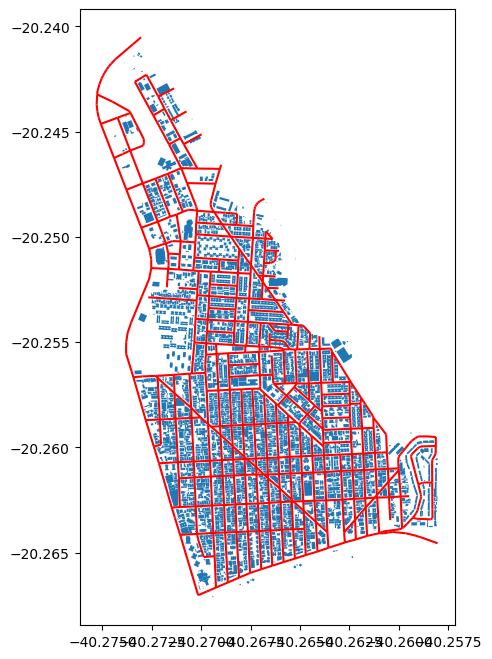

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
# fig, ax = plt.subplots()
jc_ruas.plot(ax=ax, color='red')
jc_building.plot(ax=ax)

In [49]:
# para a construção da caixa vamos a considerar o valor mais alto entre o HG e HD, o resultado é salvo em HM
# segue a mesma ideia, a media entre WG e WD, o valor é salvo em WM

jc_ruas['HM'] = jc_ruas[['HG', 'HD']].max(axis=1)
jc_ruas['W_tot'] = jc_ruas[['WG', 'WD']].sum(axis=1)

# junção das ruas e predios de acordo com a distancia
ruas_buildings = gpd.sjoin_nearest(jc_ruas, jc_building, how='left', distance_col='distancia')

ruas_buildings = ruas_buildings.drop(
    columns=['MODUL_EMIS', 'addr_subur', 'amenity', 'addr_hou_1', 'source', 'index_right',
             'name', 'type', 'WG', 'WD',  'NDDEB', 'NDFIN', 'building', 'addr_stree'])

ruas_buildings = ruas_buildings.rename(columns={'ID_left': 'ID'})


ruas_buildings
# ruas_buildings['altura'] = ruas_buildings['']

/home/georgynio/.local/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,TYPE,HG,HD,PM10,SO2,ID,LENGTH,Nome,geometry,HM,W_tot,building_l,height,ID_right,distancia
0,1,3.0,0.1,0.5431,0.03780,1,67.913778,Av. Dante Michelini (2),"LINESTRING (-40.26925 -20.26666, -40.26865 -20...",3.0,52.6,1,3,1486,0.000141
1,1,3.0,0.1,0.5431,0.03780,2,64.776768,Av. Dante Michelini (2),"LINESTRING (-40.26865 -20.26642, -40.26808 -20...",3.0,52.6,1,3,544,0.000148
2,1,3.0,0.1,0.5431,0.03780,3,63.197688,Av. Dante Michelini (2),"LINESTRING (-40.26808 -20.26619, -40.26752 -20...",3.0,52.6,6,18,543,0.000164
3,1,3.0,0.1,0.5431,0.03780,4,62.569056,Av. Dante Michelini (1),"LINESTRING (-40.26752 -20.26597, -40.26695 -20...",3.0,52.6,None,0,574,0.000159
4,1,3.0,0.1,0.5431,0.03780,5,60.976225,Av. Dante Michelini (1),"LINESTRING (-40.26695 -20.26579, -40.26640 -20...",3.0,52.6,None,0,572,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,1,0.1,0.1,0.0167,0.00036,663,49.251408,RUA ALVIM BORGES DA SILVA,"LINESTRING (-40.26092 -20.25904, -40.26063 -20...",0.1,16.0,10,30,3640,0.000101
663,1,0.1,3.0,0.0167,0.00036,664,28.470452,None,"LINESTRING (-40.26087 -20.26025, -40.26059 -20...",3.0,15.4,1,3,2168,0.000049
664,0,3.0,3.0,0.0167,0.00036,665,34.681844,AV MUNIR HILAL,"LINESTRING (-40.26087 -20.26025, -40.26120 -20...",3.0,15.4,1,3,2168,0.000051
665,1,0.1,3.0,0.0167,0.00036,666,66.234476,RUA BELMIRO TEIXEIRA PIMENTA,"LINESTRING (-40.26654 -20.25543, -40.26591 -20...",3.0,18.0,1,3,2918,0.000058


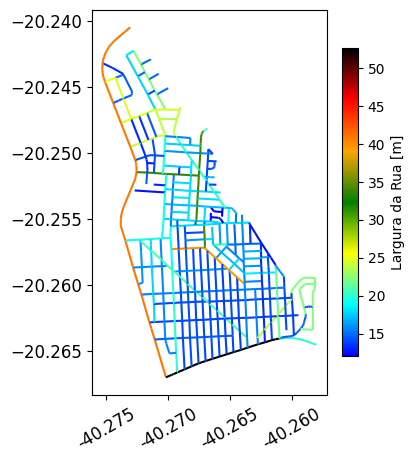

In [50]:

cmap_new = colors.LinearSegmentedColormap.from_list('', 
            [ 'blue','cyan', 'yellow', 'green', 'orange','red', 'black'])

fig, ax = plt.subplots(figsize=(4,5))

# jc_ver.plot(ax=ax, markersize=12, color='black')
jc_ruas.plot(column='W_tot', 
             ax=ax,
             cmap=cmap_new,
            #  vmin=0.4,
            #  vmax=1.2,
             legend=True,
             legend_kwds={'label': 'Largura da Rua [m]',
                          'orientation': 'vertical',
                          'fmt': "{:.0f}",
                          'shrink':0.8})
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax.tick_params(axis='x', labelsize=12, rotation=30)
ax.tick_params(axis='y', labelsize=12)
plt.savefig('network.png', dpi=300, bbox_inches='tight')

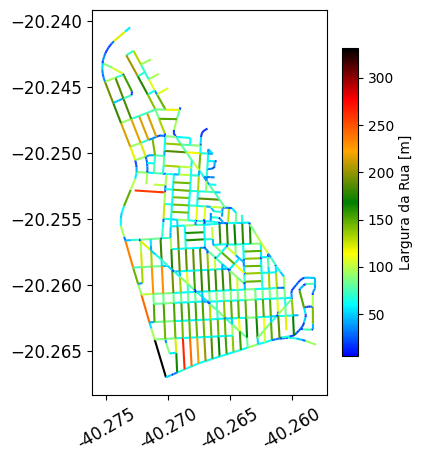

In [51]:
cmap_new = colors.LinearSegmentedColormap.from_list('', 
            [ 'blue','cyan', 'yellow', 'green', 'orange','red', 'black'])

fig, ax = plt.subplots(figsize=(4,5))

# jc_ver.plot(ax=ax, markersize=12, color='black')
jc_ruas.plot(column='LENGTH', 
             ax=ax,
             cmap=cmap_new,
            #  vmin=0.4,
            #  vmax=1.2,
             legend=True,
             legend_kwds={'label': 'Largura da Rua [m]',
                          'orientation': 'vertical',
                          'fmt': "{:.0f}",
                          'shrink':0.8})
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax.tick_params(axis='x', labelsize=12, rotation=30)
ax.tick_params(axis='y', labelsize=12)
plt.savefig('network-length.png', dpi=300, bbox_inches='tight')

/home/georgynio/.local/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


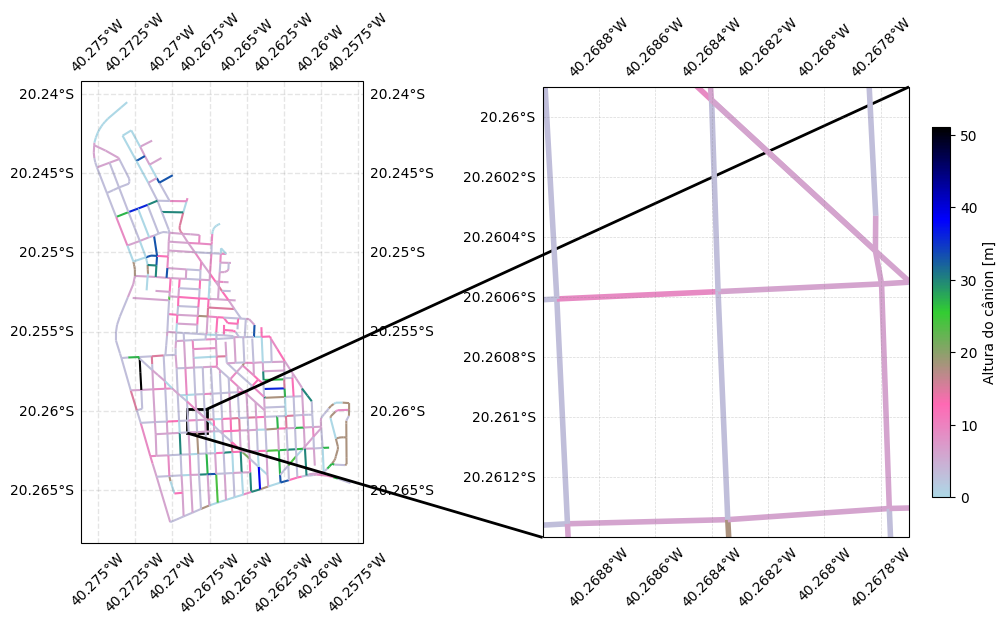

In [52]:
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

cmap_new = colors.LinearSegmentedColormap.from_list('', 
              ['#ADD8E6', '#FF69B4', '#32CD32', '#0000FF', '#000000']
)

fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)
cart_proj = ccrs.PlateCarree()  # Asegúrate de tener importado ccrs
ax1 = plt.subplot(gs[0], projection=cart_proj)
ax2 = plt.subplot(gs[1], projection=cart_proj)


# jc_ver.plot(ax=ax, markersize=12, color='black')
cax1 = ruas_buildings.plot(column='height', 
             ax=ax1,
             cmap=cmap_new,
            #  vmin=0.4,
            #  vmax=1.2,
             legend=False,
             legend_kwds={'label': 'Altura do cânion [m]',
                          'orientation': 'vertical',
                          'fmt': "{:.0f}",
                          'shrink':0.8})
# ax1.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax1.tick_params(axis='x', labelsize=12, rotation=30)
ax1.tick_params(axis='y', labelsize=12)
gl = ax1.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=1., color='gray', alpha=0.2, linestyle='--')
gl.xlabel_style = {'size': 10, 'color': 'black', 'rotation':45}
gl.ylabel_style = {'size': 10, 'color': 'black'}

ruas_buildings.plot(column='height', 
             ax=ax2,
             cmap=cmap_new,
             lw=4,
            #  vmin=0.4,
            #  vmax=1.2,
             legend=True,
             legend_kwds={'label': 'Altura do cânion [m]',
                          'orientation': 'vertical',
                          'fmt': "{:.0f}",
                          'shrink':0.8})
# ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.set_xlim([-40.269, -40.2677])
ax2.set_ylim([-20.2614, -20.2599])
ax2.tick_params(axis='x', labelsize=12, rotation=30)
ax2.tick_params(axis='y', labelsize=12)
gl = ax2.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.ylabels_right = False
gl.xlabel_style = {'size': 10, 'color': 'black', 'rotation':45}
gl.ylabel_style = {'size': 10, 'color': 'black'}
axins = mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none", ec="black", linestyle='-', lw=2) 
# cbar = fig.colorbar(cax1, cax=cax, label='Altura do cânion [m]')
                    
plt.savefig('network-height.png', dpi=300, bbox_inches='tight')

In [53]:
# prepare a dictionary with intersection elements

# Split the linestrings at the intersections
split_lines = jc_ruas.geometry.apply(lambda x: x.intersection(jc_ruas.unary_union))

# Flatten the resulting list of linestrings into a single GeoDataFrame
split_lines_gdf = gpd.GeoDataFrame({'geometry': split_lines.explode()})

# Create a dictionary to store the segments that are connected to each intersection
segments = {}

# Iterate through the segments and add them to the dictionary
for index, row in split_lines_gdf.iterrows():
    start_point = tuple(row['geometry'].coords[0])
    end_point = tuple(row['geometry'].coords[-1])
    if start_point in segments:
        segments[start_point].append(index[0])
    else:
        segments[start_point] = [index[0]]
    if end_point in segments:
        segments[end_point].append(index[0])
    else:
        segments[end_point] = [index[0]]



/tmp/ipykernel_582269/571049438.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  split_lines_gdf = gpd.GeoDataFrame({'geometry': split_lines.explode()})


In [54]:
geometry = [Point(p) for p in segments.keys()]
intersection_jc = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')
intersection_jc['streets'] = segments.values()
for i, row in intersection_jc.iterrows():
    intersection_jc.loc[i, 'id'] = i+1
    intersection_jc.loc[i, 'num_ruas'] = len(row['streets'])
    intersection_jc.loc[i, 'long'] = row.geometry.x
    intersection_jc.loc[i, 'lat'] = row.geometry.y


In [55]:
linestring_nodes = {}

# Loop through each linestring
for i, row in jc_ruas.iterrows():
    # Find the intersection that is the initial node for the linestring
    jc_ruas.at[i, 'ini_node'] = intersection_jc[intersection_jc.intersects(Point(row["geometry"].coords[0]))]["id"].iloc[0]
    # Find the intersection that is the final node for the linestring
    jc_ruas.at[i, 'end_node'] = intersection_jc[intersection_jc.intersects(Point(row["geometry"].coords[-1]))]["id"].iloc[0]
    # Store the initial and final nodes in the dictionary

jc_ruas.head()

,TYPE,NDDEB,NDFIN,WG,WD,HG,HD,MODUL_EMIS,PM10,SO2,ID,LENGTH,Nome,geometry,HM,W_tot,ini_node,end_node
0,1,431,432,26.3,26.3,3.0,0.1,0,0.5431,0.0378,1,67.913778,Av. Dante Michelini (2),"LINESTRING (-40.26925 -20.26666, -40.26865 -20...",3.0,52.6,1.0,2.0
1,1,432,433,26.3,26.3,3.0,0.1,0,0.5431,0.0378,2,64.776768,Av. Dante Michelini (2),"LINESTRING (-40.26865 -20.26642, -40.26808 -20...",3.0,52.6,2.0,3.0
2,1,433,434,26.3,26.3,3.0,0.1,0,0.5431,0.0378,3,63.197688,Av. Dante Michelini (2),"LINESTRING (-40.26808 -20.26619, -40.26752 -20...",3.0,52.6,3.0,4.0
3,1,434,435,26.3,26.3,3.0,0.1,0,0.5431,0.0378,4,62.569056,Av. Dante Michelini (1),"LINESTRING (-40.26752 -20.26597, -40.26695 -20...",3.0,52.6,4.0,5.0
4,1,435,436,26.3,26.3,3.0,0.1,0,0.5431,0.0378,5,60.976225,Av. Dante Michelini (1),"LINESTRING (-40.26695 -20.26579, -40.26640 -20...",3.0,52.6,5.0,6.0


In [56]:
nearest = gpd.sjoin_nearest(jc_ruas, jc_building)
nearest.index = nearest['ID_left']
nearest = nearest.sort_index()
height = list(nearest.iloc[jc_ruas.ID-1]['height'])


/home/georgynio/.local/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [57]:
ruas_buildings

,TYPE,HG,HD,PM10,SO2,ID,LENGTH,Nome,geometry,HM,W_tot,building_l,height,ID_right,distancia
0,1,3.0,0.1,0.5431,0.03780,1,67.913778,Av. Dante Michelini (2),"LINESTRING (-40.26925 -20.26666, -40.26865 -20...",3.0,52.6,1,3,1486,0.000141
1,1,3.0,0.1,0.5431,0.03780,2,64.776768,Av. Dante Michelini (2),"LINESTRING (-40.26865 -20.26642, -40.26808 -20...",3.0,52.6,1,3,544,0.000148
2,1,3.0,0.1,0.5431,0.03780,3,63.197688,Av. Dante Michelini (2),"LINESTRING (-40.26808 -20.26619, -40.26752 -20...",3.0,52.6,6,18,543,0.000164
3,1,3.0,0.1,0.5431,0.03780,4,62.569056,Av. Dante Michelini (1),"LINESTRING (-40.26752 -20.26597, -40.26695 -20...",3.0,52.6,None,0,574,0.000159
4,1,3.0,0.1,0.5431,0.03780,5,60.976225,Av. Dante Michelini (1),"LINESTRING (-40.26695 -20.26579, -40.26640 -20...",3.0,52.6,None,0,572,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,1,0.1,0.1,0.0167,0.00036,663,49.251408,RUA ALVIM BORGES DA SILVA,"LINESTRING (-40.26092 -20.25904, -40.26063 -20...",0.1,16.0,10,30,3640,0.000101
663,1,0.1,3.0,0.0167,0.00036,664,28.470452,None,"LINESTRING (-40.26087 -20.26025, -40.26059 -20...",3.0,15.4,1,3,2168,0.000049
664,0,3.0,3.0,0.0167,0.00036,665,34.681844,AV MUNIR HILAL,"LINESTRING (-40.26087 -20.26025, -40.26120 -20...",3.0,15.4,1,3,2168,0.000051
665,1,0.1,3.0,0.0167,0.00036,666,66.234476,RUA BELMIRO TEIXEIRA PIMENTA,"LINESTRING (-40.26654 -20.25543, -40.26591 -20...",3.0,18.0,1,3,2918,0.000058


In [58]:
# colocando altura 3 metros caso a não existe predio do lado
ruas_buildings.loc[ruas_buildings['height']==0, 'height'] = 3

# Escenario específico
escenario = 'cenario-wudapt'

# Definir las alturas correspondientes a cada escenario
alturas_por_escenario = {
    'cenario-base': None,
    'cenario-1': 6,
    'cenario-2': 9,
    'cenario-3': 12,
    'cenario-4': 15,
    'cenario-5': 18,
    'cenario-wudapt': 10,
}

# Colocar alturas según el escenario
altura_predeterminada = alturas_por_escenario.get(escenario, 3)
if 'wudapt' in escenario:
    ruas_buildings.loc[:, 'height'] = altura_predeterminada
else:
    ruas_buildings.loc[ruas_buildings['height'] < altura_predeterminada, 'height'] = altura_predeterminada

# prepare the street-geog-info.dat file
# second case
# we use 3 meters as unique height or 0.1 meters to represent opened area
cabeca1 = '#id,length,width,height'
df1 = pd.DataFrame(columns=cabeca1.split(','))

df1['#id'] = ruas_buildings['ID']
df1['length'] = ruas_buildings['LENGTH']
df1['width'] = ruas_buildings['W_tot']
df1['height'] = ruas_buildings['height']
nome_arquivo = f'street-geog-{escenario}.dat'
df1.to_csv(nome_arquivo, sep='\t', index=False)
df1

,#id,length,width,height
0,1,67.913778,52.6,10
1,2,64.776768,52.6,10
2,3,63.197688,52.6,10
3,4,62.569056,52.6,10
4,5,60.976225,52.6,10
...,...,...,...,...
662,663,49.251408,16.0,10
663,664,28.470452,15.4,10
664,665,34.681844,15.4,10
665,666,66.234476,18.0,10


In [59]:
cabeca1 = '#id,length,width,height'
cabeca1.split(',')

['#id', 'length', 'width', 'height']

<Axes: >

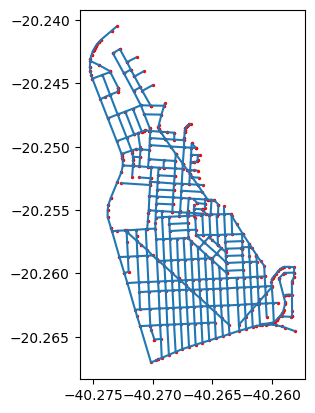

In [60]:
fig, ax = plt.subplots()
jc_ruas.plot(ax=ax)
intersection_jc.plot(ax=ax, color='red', markersize=2)


In [61]:
# prepare the intersection.dat file

cabeca2 = '#id;lon;lat;number_of_streets;1st_street_id;2nd_street_id;...'
cabeca2 = cabeca2.split(';')
df2 = gpd.GeoDataFrame({
    cabeca2[0]: map(int, intersection_jc.id),
    cabeca2[1]: intersection_jc.long,
    cabeca2[2]: intersection_jc.lat,
    cabeca2[3]: map(int,intersection_jc.num_ruas),
    cabeca2[4]: intersection_jc.streets.apply(lambda x: ';'.join(map(str, x))),
    # cabeca2[5]: intersection_jc.node_end
})
df2.to_csv('intersection_jc.dat', sep=';', index=False)
df2


,#id,lon,lat,number_of_streets,1st_street_id
0,1,-40.269249,-20.266658,3,0;69;625
1,2,-40.268650,-20.266422,3,0;1;72
2,3,-40.268081,-20.266189,3,1;2;149
3,4,-40.267523,-20.265968,3,2;3;75
4,5,-40.266955,-20.265790,3,3;4;144
...,...,...,...,...,...
768,769,-40.261881,-20.258618,2,659;660
769,770,-40.260917,-20.259036,2,661;662
770,771,-40.260867,-20.260245,2,663;664
771,772,-40.266538,-20.255434,2,665;666
